In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Path of English-Spanish aligned sentences
data_path = "/content/drive/My Drive/Spanish_Bible_Translation/spa.txt"

# There are over 120000 samples. To conserve memory, we will randomly sample 30,000 out of the first 50,000
num_samples = 70000
lines_to_consider = 80000

In [0]:
# Read the file
with open(data_path, 'r', encoding='utf-8') as p:
  lines = p.read().split('\n')

  print(len(lines))

122937


## Text Preprocessing
Now that we've read the lines from the file, we will need to perform all the necessary preprocessing steps. In this case, we will convert the sentences to all lower-case and remove and special characters. 

In [0]:
# Borrowed from 
# https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/feature%20engineering%20text%20data/Feature%20Engineering%20Text%20Data%20-%20Traditional%20Strategies.ipynb
import nltk
import re
import numpy as np

wpt = nltk.WordPunctTokenizer()

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub("[^\w\s]", "", doc);

    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)

    # re-create document from filtered tokens
    doc = ' '.join(tokens)
    return doc

Looking through the training data, we see that the sentences start out short and tend to get longer as we proceed through the file. To remedy this, we randomize the selection of sentences that we will train our model on. This will make sure our model is validated on a similar set of sentences to the training data.

In [0]:
# Because the translated sentences seem to get longer as we proceed through the file,
# we will randomize our selection of the sentences. 
import random

# Store each of the English and Spanish language statements in two arrays
eng_sents = []
span_sents = []

# Select a random set of indices out of the first 50.000 sentences. 
random_idx = random.sample(range(0, lines_to_consider-1), num_samples)

# Grab the randomized lines
lines_randomized = []
for idx in random_idx:
  lines_randomized.append(lines[idx])

# Split the lines into English and Spanish equivalents
for line in lines_randomized:
  eng, span, _ = line.split('\t')


  eng_sents.append(normalize_document(eng))
  # Add start and stop tokens to target language phrases 
  span_sents.append('START_ ' + normalize_document(span) + ' _END')

In [0]:
import os
import tqdm
import numpy as np
import gensim

from collections import defaultdict

Now we create a set containing all English words in the corpus. It's a good idea to see how long the longest sentence is, and the average length of all the sentences. This will help us establish how long we want our input sequences to be. 

In [0]:
# We create a set to make sure every word is stored only once
eng_words = set()

for sent in eng_sents:
  for word in sent.split():
    eng_words.add(word)

In [0]:
# list of all sentence lengths
eng_sent_lens = [len(sent.split()) for sent in eng_sents]

In [0]:
print("Number of unique English words: ", len(eng_words))
print("Average English sentence length: ", np.mean(eng_sent_lens))
print("Longest English sentence length: ", np.max(eng_sent_lens))

Number of unique English words:  9002
Average English sentence length:  4.922657142857143
Longest English sentence length:  10


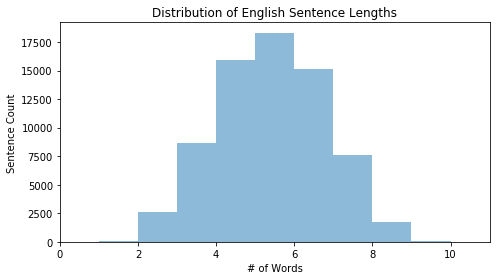

In [0]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(7, 4))

# fixed bin size
bins = np.arange(0, max(eng_sent_lens)+1, 1) # fixed bin size

color = 'tab:blue'
ax1.set_xlabel('# of Words')
ax1.set_ylabel('Sentence Count')
ax1.set_xlim([min(eng_sent_lens)-1, max(eng_sent_lens)+1])
ax1.hist(eng_sent_lens, bins=bins, alpha=0.5, color=color)
plt.title("Distribution of English Sentence Lengths")


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [0]:
unique, counts = np.unique(eng_sent_lens, return_counts=True)
dict(zip(unique, counts))

{1: 53,
 2: 2572,
 3: 8645,
 4: 15956,
 5: 18300,
 6: 15101,
 7: 7571,
 8: 1695,
 9: 103,
 10: 4}

In [0]:
eng_word_cnts = dict()

for sent in eng_sents:
  for wrd in sent.split(" "):
    if wrd in eng_word_cnts:
      eng_word_cnts[wrd] += 1
    else:
      eng_word_cnts[wrd] = 1

In [0]:
eng_word_cnts_array = [eng_word_cnts[wrd] for wrd in eng_word_cnts]

In [0]:
eng_wrds = [wrd for wrd in eng_word_cnts if eng_word_cnts[wrd] > 2]

In [0]:
eng_wrds.append('_UNK_')

In [0]:
len(eng_wrds)

4587

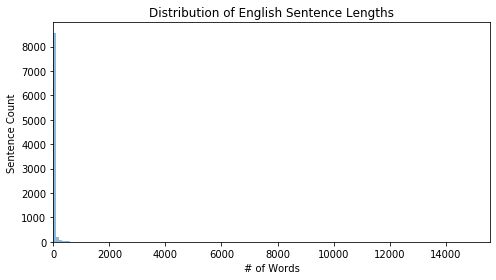

In [0]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(7, 4))

# fixed bin size
bins = np.arange(0, max(eng_word_cnts_array)+1, 100) # fixed bin size

color = 'tab:blue'
ax1.set_xlabel('# of Words')
ax1.set_ylabel('Sentence Count')
ax1.set_xlim([min(eng_word_cnts_array)-1, max(eng_word_cnts_array)+1])
ax1.hist(eng_word_cnts_array, bins=bins, alpha=0.5, color=color)
plt.title("Distribution of English Sentence Lengths")


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Visually, we see the sentence lengths seem to follow a normal distribution with a slight skew to the left. For our purposes, setting the input sequence length to 6 should contain over 99% of our sentences while saving RAM when creating the input arrays later on.

In [0]:
input_seq_len = 8

Same exercise for the output language:

In [0]:
# We create a set to make sure every word is stored only once
span_words = set()

for sent in span_sents:
  for word in sent.split():
    span_words.add(word)

In [0]:
# list of all Spanish sentence lengths
span_sent_lens = [len(sent.split()) for sent in span_sents]

In [0]:
print("Number of unique Spanish words: ", len(span_words))
print("Average Spanish sentence length: ", np.mean(span_sent_lens))
print("Longest Spanish sentence length: ", max(span_sent_lens))

Number of unique Spanish words:  17264
Average Spanish sentence length:  6.720285714285715
Longest Spanish sentence length:  17


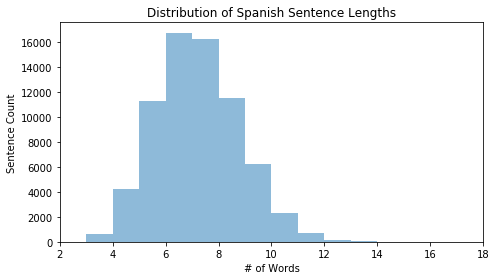

In [0]:
fig, ax1 = plt.subplots(figsize=(7, 4))

# fixed bin size
bins = np.arange(0, max(span_sent_lens)+1, 1) # fixed bin size

color = 'tab:blue'
ax1.set_xlabel('# of Words')
ax1.set_ylabel('Sentence Count')
ax1.set_xlim([min(span_sent_lens)-1, max(span_sent_lens)+1])
ax1.hist(span_sent_lens, bins=bins, alpha=0.5, color=color)
plt.title("Distribution of Spanish Sentence Lengths")


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [0]:
unique, counts = np.unique(span_sent_lens, return_counts=True)
dict(zip(unique, counts))

{3: 620,
 4: 4215,
 5: 11267,
 6: 16725,
 7: 16220,
 8: 11546,
 9: 6196,
 10: 2299,
 11: 673,
 12: 180,
 13: 42,
 14: 14,
 15: 1,
 16: 1,
 17: 1}

The distribution of the Spanish sentences appears to have a tail on the right side. It appears we can contain 99% of our sentences by clipping the output sequence length at 11. This should save us quite a bit of RAM later on. 

In [0]:
output_seq_len = 11

In [0]:
span_word_cnts = dict()

for sent in span_sents:
  for wrd in sent.split(" "):
    if wrd in span_word_cnts:
      span_word_cnts[wrd] += 1
    else:
      span_word_cnts[wrd] = 1

In [0]:
span_word_cnts_array = [span_word_cnts[wrd] for wrd in span_word_cnts]

In [0]:
span_wrds = [wrd for wrd in span_word_cnts if span_word_cnts[wrd] > 2]

In [0]:
span_wrds.append('_UNK_')
print(len(span_wrds))

6915


In [0]:
input_words = sorted(list(eng_wrds))
num_encoder_tokens = len(eng_wrds)
del eng_words


In [0]:
del eng_wrds

In [0]:
output_words = sorted(list(span_wrds))
num_decoder_tokens = len(span_wrds)
del span_words

In [0]:
del span_wrds

# Import FastText Word Embeddings

For this exercise, we want to see if using the pretrained embeddings provided by Facebook's Fasttext will give our model an edge. Using pretrained embeddings should provide an advantage because the embeddings bring in much more context knowledge for the individual words based on a much larger sample corpus of millions of texts. Our dataset provides nowhere near enough training material.

In [0]:
from gensim.models import FastText

In [0]:
from gensim.models import KeyedVectors
ft_eng = KeyedVectors.load("/content/drive/My Drive/Spanish_Bible_Translation/fasttext_gensim_en.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Handling Out-of-Vocabulary (OOV) Words
In any large corpus, you are bound to encounter words that the popular pretrained word embeddings like FastText and Word2Vec do not account for. You need a robust way to handle these. 

One approach is to create random word embeddings for OOV words. However, this introduces the risk of the OOV word embeddings being complete outliers in the word embedding vector space. A simple remedy for this is to take the average and standard deviation of all the other word embeddings in the corpus, and making sure your random embeddings fall within those distributions. This will make sure your OOV word embeddings are not out of this world.

In [0]:
input_oov_words = []

for i, wrd in enumerate(input_words):
  if wrd not in ft_eng.vocab:
    input_oov_words.append(wrd)

print("Number of English OOV words: ", len(input_oov_words))

Number of English OOV words:  6


We see that the OOV words make up a very small portion of the total vocabulary, which suggests that we are okay to try the method outlined above. 

In [0]:
# Create a dictionary that 

#https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge
input_embeddings_index = dict()

for i, word in enumerate(input_words):
  try:
    embedding_vector = ft_eng.get_vector(word)
  except KeyError:
    embedding_vector = None
  #embedding_vector = ft_eng.get_vector(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    input_embeddings_index[i] = embedding_vector

To make our OOV word embeddings consistent with the existing word embeddings, we take the mean and standard deviation of the existing word embeddings. The OOV word embeddings now consist of random numbers within the normal range of the existing word embeddings.

In [0]:
# https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge
#We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
all_embs = np.stack(list(input_embeddings_index.values()))
inp_emb_mean,inp_emb_std = all_embs.mean(), all_embs.std()
del all_embs

In [0]:
#https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge
input_oov_embeddings = dict()

rare_embedding = np.random.normal(inp_emb_mean, inp_emb_std, 300)

for wrd in input_oov_words:
  input_oov_embeddings[wrd] = np.random.normal(inp_emb_mean, inp_emb_std, 300)

In [0]:
del input_embeddings_index

We now have everything we need to create our input word embedding matrix that consist of the embeddings for every word of every sentence of our training corpus.

In [0]:
input_embedding_matrix = np.zeros((len(input_words), 300))
for i, word in enumerate(input_words):
  if word == '_UNK_':
    input_embedding_matrix[i] = rare_embedding
  else:
    try:
      embedding_vector = ft_eng.get_vector(word)
    except KeyError:
      embedding_vector = None
    #embedding_vector = ft_eng.get_vector(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all-zeros.
      input_embedding_matrix[i] = embedding_vector
    else:
      input_embedding_matrix[i] = input_oov_embeddings[word]

In [0]:
del ft_eng

In [0]:
del input_oov_words

###  Spanish FastText Word Embeddings
We repeat the above procedure for the Spanish language FastText embeddings. At the end we will have the output embedding vectors for every word of every sentence of the training corpus. 

In [0]:
# Original fasttext embeddings from https://fasttext.cc/
ft_span = KeyedVectors.load("/content/drive/My Drive/Spanish_Bible_Translation/fasttext_gensim_span.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
output_oov_words = []

for i, wrd in enumerate(output_words):
  if wrd not in ft_span.vocab:
    output_oov_words.append(wrd)

print(len(output_oov_words))

6


In [0]:
#https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge
output_embeddings_index = dict()

for i, word in enumerate(output_words):
  try:
    embedding_vector = ft_span.get_vector(word)
  except KeyError:
    embedding_vector = None
  #embedding_vector = ft_span.get_vector(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    output_embeddings_index[i] = embedding_vector

In [0]:
# https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge
#We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
all_embs = np.stack(list(output_embeddings_index.values()))
out_emb_mean,out_emb_std = all_embs.mean(), all_embs.std()
del all_embs

In [0]:
#https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge
output_oov_embeddings = dict()

for wrd in output_oov_words:
  if wrd == "START_" or wrd == "_END":
    print(wrd)
    output_oov_embeddings[wrd] = np.zeros(300)
  else:
    output_oov_embeddings[wrd] = np.random.normal(out_emb_mean, out_emb_std, 300)

START_
_END


In [0]:
span_rare_embedding = np.random.normal(out_emb_mean, out_emb_std, 300)

In [0]:
del output_embeddings_index

In [0]:
output_embedding_matrix = np.zeros((len(output_words), 302))
for i, word in enumerate(output_words):
  if word == "START_":
    print(i)
    output_embedding_matrix[i, 300] = 1
  elif word == "_END":
    print(i)
    output_embedding_matrix[i, 301] = 1
  elif word == "_UNK_":
    output_embedding_matrix[i, :300] = span_rare_embedding
  else:
    try:
      embedding_vector = ft_span.get_vector(word)
    except KeyError:
      embedding_vector = None
    if embedding_vector is not None:
      if word == 'START_':
        print(word)
      # words not found in embedding index will be all-zeros.
      output_embedding_matrix[i, :300] = embedding_vector
    else:
      if word == "START_":
        print(output_oov_embeddings[word])
      output_embedding_matrix[i, :300] = output_oov_embeddings[word]

33
34


In [0]:
del ft_span

In [0]:
del output_oov_words

## Preparing the Data for our Neural Network
In order to train our neural network, we need to convert the text data into numerical data that our neural network can learn from. Up to this point, we have put together the tools necessary to convert our data. Now we need to create the actual matrices that our neural network will use.

In [0]:
# Dictionary that stores each word as a unique index
input_token_index = dict(
    [(word, i) for i, word in enumerate(input_words)])

In [0]:
# Dictionary that stores each word as a unique index
target_token_index = dict(
    [(word, i) for i, word in enumerate(output_words)])

We prepare three matrices. The first matrix is the encoder input matrix.

The second and third matrices will both be for the decoder. The decoder input matrix sentences will start with the START token. The decoder output matrix will be offset by one token, starting with the first actual token of the sentence. This will train our decoder to predict the next word given the thought vector from the encoder, and the START token. It will then use the output as the input to predict the next token. Training the decoder in this way is called Teacher Forcing. Basically, instead of expecting the decoder to learn to output the whole phrase, we train it at each token and penalize the loss function if the next token is incorrect. Teacher forcing should improve the performance of our model. 

In [0]:
encoder_input_data = np.zeros((num_samples, input_seq_len), dtype='float32')

In [0]:
decoder_input_data = np.zeros((num_samples, output_seq_len), dtype='float32')

In [0]:
decoder_target_data = np.zeros((num_samples, output_seq_len, len(output_words)), dtype='float32')

In [0]:
# Vectorize the encoder input sentences by storing the word indices in the input matrix
for i, input_text in enumerate(eng_sents):
    for t, word in enumerate(input_text.split()):
      if t < input_seq_len:
        if word in input_words:
          encoder_input_data[i, t] = input_token_index[word]
        else:
          # if the word is not in the input_words matrix, store it as '_UNK_' for unknown
          encoder_input_data[i, t] = input_token_index['_UNK_']

In [0]:
# Vectorize the decoder input and output sentences
for i, output_text in enumerate(span_sents):
  for t, word in enumerate(output_text.split()):
    if word in output_words:
      if t < output_seq_len:
        decoder_input_data[i, t] = target_token_index[word]

      # the decoder output matrix is offset by one token
      if t > 0 and t < output_seq_len+1:
        decoder_target_data[i, t-1, target_token_index[word]] = 1.
    
    else:
      # if the word is not in the output_words matrix, store it as '_UNK_' for unknown
      if t < output_seq_len:
        decoder_input_data[i, t] = target_token_index['_UNK_']
      if t > 0 and t < output_seq_len+1:
        decoder_target_data[i, t-1, target_token_index['_UNK_']] = 1.


## Assembling our Neural Network
With our training data vectorized, we are now ready to assemble our encoder-decoder neural network. 

In [0]:
from keras.layers import Input, CuDNNLSTM, Embedding, Dense
from keras.models import Model
from keras.utils import plot_model

Using TensorFlow backend.


### Encoder
To take advantage of the pretrained word embeddings that we've imported, we create an Embedding layer and set the weights equal to the input_embedding_matrix. We make sure to set the trainable parameter to False so that our word embeddings stay the same throughout the learning process. 

In [0]:
encoder_inputs = Input(shape=(None,))
en_x=  Embedding(len(input_words),
                            300,
                            weights=[input_embedding_matrix],
                            trainable=False)(encoder_inputs)
encoder = CuDNNLSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder(en_x)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

### Decoder 
Our decoder also consists of an embedding layer to hold our pre-trained FastText word embeddings. This time we set the dimension to 302 to hold the extra START and END token columns. 

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dex=  Embedding(len(output_words),
                302,
                weights=[output_embedding_matrix],
                trainable=False)
final_dex= dex(decoder_inputs)


decoder_lstm = CuDNNLSTM(50, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(final_dex,
                                     initial_state=encoder_states)

decoder_dense = Dense(len(output_words), activation='softmax')

decoder_outputs = decoder_dense(decoder_outputs)

# Our neural network model takes both encoder_inputs and decoder_inputs as inputs, with the output being decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    1376100     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 302)    2088330     input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
#from keras.callbacks import EarlyStopping

In [0]:
#EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

We fit our model and find that the validation loss seems to stabilize after about 115 epochs. We use a traditional 80/20 split of the train validation data. 

In [0]:
model.fit(x=[encoder_input_data, decoder_input_data], y=decoder_target_data,
          batch_size=128,
          epochs=70, 
          validation_split=0.20
          )

Train on 56000 samples, validate on 14000 samples
Epoch 1/70
56000/56000 [==============================] - 33s 593us/step - loss: 1.2441 - acc: 0.3060 - val_loss: 1.4001 - val_acc: 0.2878
Epoch 2/70
56000/56000 [==============================] - 33s 590us/step - loss: 1.2422 - acc: 0.3064 - val_loss: 1.4021 - val_acc: 0.2873
Epoch 3/70
56000/56000 [==============================] - 33s 592us/step - loss: 1.2403 - acc: 0.3067 - val_loss: 1.3980 - val_acc: 0.2871
Epoch 4/70
56000/56000 [==============================] - 33s 588us/step - loss: 1.2388 - acc: 0.3067 - val_loss: 1.3989 - val_acc: 0.2868
Epoch 5/70
56000/56000 [==============================] - 33s 590us/step - loss: 1.2370 - acc: 0.3073 - val_loss: 1.3988 - val_acc: 0.2873
Epoch 6/70
56000/56000 [==============================] - 33s 590us/step - loss: 1.2350 - acc: 0.3080 - val_loss: 1.3949 - val_acc: 0.2878
Epoch 7/70
56000/56000 [==============================] - 33s 592us/step - loss: 1.2329 - acc: 0.3082 - val_loss: 1.

KeyboardInterrupt: ignored

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 300)         1376100   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     [(None, 50), (None, 50),  70400     
Total params: 1,446,500
Trainable params: 70,400
Non-trainable params: 1,376,100
_________________________________________________________________


In [0]:
decoder_state_input_h = Input(shape=(50,))
decoder_state_input_c = Input(shape=(50,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

final_dex2= dex(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 51:
          print(reverse_target_char_index[sampled_token_index])

        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence.split()) > output_seq_len):
          print(sampled_char)
          print(len(decoded_sentence.split()))
          stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [0]:
test_phrase = "i see you"

test_phrase_input_vector = np.zeros((1, input_seq_len), dtype='float32')
test_phrase__output_vector = np.zeros((1, output_seq_len, len(output_words)), dtype='float32')

for t, word in enumerate(test_phrase.split()):
  try:
    tok_ind = input_token_index[word]
  except KeyError:
    tok_ind = None
  
  if tok_ind is not None:
    test_phrase_input_vector[0, t] = input_token_index[word]
  else:
    test_phrase_input_vector[0, t] = input_token_index['_UNK_']

#test_phrase_input_vector[0, t+1:, input_token_index[' ']] = 1.


In [0]:
#test_phrase_input_vector
print(test_phrase)
decoded_sent = decode_sequence(test_phrase_input_vector)

print(decoded_sent)

i see you
_END
3
 te veo _END


In [0]:
#rand_idx = random.sample(test_idx, 100)

rand_idx = random.sample(range(0, 70000), 100)

for seq_index in rand_idx:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', eng_sents[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)

_END
5
-
Input sentence: ['come back here immediately']
Decoded sentence:  vuelve aquí por favor _END
_END
9
-
Input sentence: ['lets do only one thing at a time']
Decoded sentence:  solo una vez una vez en la misma _END
_END
5
-
Input sentence: ['i love ice cream']
Decoded sentence:  me gusta el _UNK_ _END
_END
3
-
Input sentence: ['no way']
Decoded sentence:  de nadie _END
_END
7
-
Input sentence: ['they caught foxes with traps']
Decoded sentence:  ellos _UNK_ _UNK_ _UNK_ de _UNK_ _END
_END
4
-
Input sentence: ['youre so talented']
Decoded sentence:  eres tan grande _END
_END
4
-
Input sentence: ['there were no jobs']
Decoded sentence:  no tenemos muchos _END
_END
9
-
Input sentence: ['i didnt mind sitting by myself']
Decoded sentence:  no me he estado solo en esa hora _END
_END
7
-
Input sentence: ['whats toms full name']
Decoded sentence:  cuál es el nombre de tom _END
_END
4
-
Input sentence: ['it was from tom']
Decoded sentence:  fue de tom _END
_END
5
-
Input sentence: ['tom lef

In [0]:
answer_vec = ft.get_vector('dogs') - ft.get_vector('dog')

In [0]:
answer_vec2 = ft.get_vector('cat') - ft.get_vector('cats')

In [0]:
ft.cosine_similarities(answer_vec, [answer_vec2])

array([-0.7573222], dtype=float32)

In [0]:
ft.most_similar(positive=[answer_vec], topn=2)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('OCCs', 0.2844681143760681), ('SPMs', 0.2560500204563141)]

In [0]:
ft.most_similar(positive=[answer_vec2], topn=2)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Units', 0.2607120871543884), ('busloads', 0.24602153897285461)]